In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import cv2
import math
import random
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from google.colab import drive

IMG_SIZE = 224

In [2]:
vgg = VGG16(input_shape=[IMG_SIZE, IMG_SIZE, 3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [3]:
for layer in vgg.layers:
  layer.trainable = False

In [4]:
drive.mount('/content/drive') 
DATADIR = "/content/drive/MyDrive/Colab Notebooks/dataset-11/*" 
CATEGORIES = glob(DATADIR)
for i in range(len(CATEGORIES)):
  CATEGORIES[i] = CATEGORIES[i].replace('/content/drive/MyDrive/Colab Notebooks/dataset-11/','')
print(CATEGORIES)


Mounted at /content/drive
['90', '60', '70', '80', '50', '20', '100', '40', '30', '10', '0']


In [5]:
from keras.layers import Dense, Flatten
x = Flatten()(vgg.output)
prediction = Dense(len(CATEGORIES), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

In [6]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

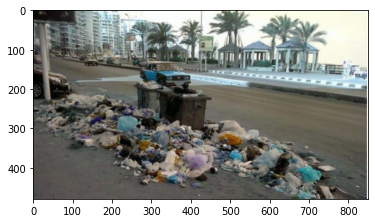

In [7]:
DATADIR = DATADIR.replace('/*',"")
for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path, img))  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!
        break  # we just want one for now so break
    break  # ...and one more!


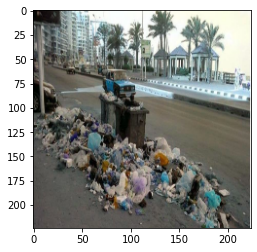

In [8]:
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [9]:
training_data = []
def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR, category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                # img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)  # convert to array
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

In [10]:
create_training_data()

100%|██████████| 236/236 [02:02<00:00,  1.93it/s]


In [11]:
random.seed(42)
random.shuffle(training_data)

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X, dtype="float") / 255.0
y = np.array(y)

In [12]:
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [14]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [15]:
print("shape of X",X.shape)
print("shape of y",y.shape)
print("shape of trainX",trainX.shape)
print("shape of trainY",trainY.shape)
print("shape of testX",testX.shape)
print("shape of testY",testY.shape)
print("length of trainX", len(trainX))

shape of X (2562, 224, 224, 3)
shape of y (2562,)
shape of trainX (1921, 224, 224, 3)
shape of trainY (1921, 11)
shape of testX (641, 224, 224, 3)
shape of testY (641, 11)
length of trainX 1921


In [16]:
INIT_LR = 0.001
EPOCHS = 170
BS = 32
# initialize the model and optimizer (you'll want to use
# binary_crossentropy or sparse_categorical_crossentropy for 2-class classification)
print("[INFO] training network...")
# opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])

# model.compile(optimizer='Adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

steps_per_epoch=len(trainX) // BS
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),steps_per_epoch=steps_per_epoch, validation_data=(testX, testY), epochs=EPOCHS)

[INFO] training network...
Epoch 1/170
60/60 [==============================] - 73s 430ms/step - loss: 2.2980 - accuracy: 0.2917 - val_loss: 1.2735 - val_accuracy: 0.5445
Epoch 2/170
60/60 [==============================] - 24s 403ms/step - loss: 1.4657 - accuracy: 0.5273 - val_loss: 1.0090 - val_accuracy: 0.6459
Epoch 3/170
60/60 [==============================] - 23s 382ms/step - loss: 1.2815 - accuracy: 0.5797 - val_loss: 0.8690 - val_accuracy: 0.6880
Epoch 4/170
60/60 [==============================] - 23s 391ms/step - loss: 0.9950 - accuracy: 0.6687 - val_loss: 0.6304 - val_accuracy: 0.7613
Epoch 5/170
60/60 [==============================] - 23s 393ms/step - loss: 0.9555 - accuracy: 0.7038 - val_loss: 0.5966 - val_accuracy: 0.7925
Epoch 6/170
60/60 [==============================] - 23s 380ms/step - loss: 0.7356 - accuracy: 0.7503 - val_loss: 0.5226 - val_accuracy: 0.8175
Epoch 7/170
60/60 [==============================] - 23s 396ms/step - loss: 0.5589 - accuracy: 0.8099 - val_l

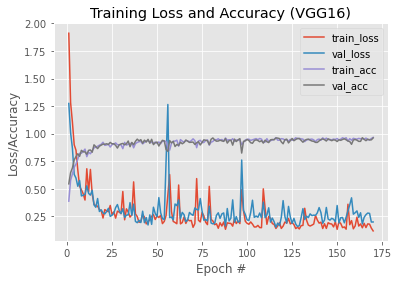

In [17]:
N = np.arange(1, EPOCHS+1)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (VGG16)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
def prepare(img_array):
    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    img_array = np.array(img_array, dtype="float") / 255.0
    img_array = img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    return img_array

def getClassTag(prediction):
    maximum = 0
    index = 0
    for i in range(len(CATEGORIES)):
        if (prediction[0][i]) > maximum:
            index = i
            maximum = prediction[0][i]

        text = "{0}".format(CATEGORIES[index])
    return(text)

def getAccuracy(prediction):
    maximum = 0
    index = 0
    for i in range(len(CATEGORIES)):
        if (prediction[0][i]) > maximum:
            index = i
            maximum = prediction[0][i]

        text = " -acc:{1}%".format(round(maximum*100, 2))
    return(text)

In [ ]:
import glob
imags = [cv2.imread(file) for file in glob.glob("/content/drive/MyDrive/Colab Notebooks/test2/*.jpg")]
print('found', len(imags), 'files')



SubDir = "/content/drive/MyDrive/Colab Notebooks/test2/"

imags = []
names = []
for ext in ('*.jpeg', '*.jpg', '*.png'):
    imags.extend([cv2.imread(file) for file in glob.glob(SubDir+ext)])
    names.extend([os.path.basename(file).replace('.jpg','').replace('.jpeg', '').replace('.png', '') for file in glob.glob(SubDir +ext)])

print(len(imags),"-",len(names))

found 26 files
36 - 36


In [ ]:
fig = plt.figure(figsize=(20, len(imags)*2))
columns = 3
rows = math.ceil(len(imags) / columns)
for i in range(len(imags)):
    ax = fig.add_subplot(rows, columns, i+1)
    class_tag = getClassTag(model.predict(prepare(cv2.resize(imags[i], (IMG_SIZE, IMG_SIZE)))))
    # class_tag = getDigitName(model.predict(prepare(cv2.resize(imags[i], (IMG_SIZE, IMG_SIZE)))))
    
    # ax.set_title(class_tag_to_name(class_tag), fontsize=18)
    ax.set_title(class_tag, fontsize=18)
    plt.axis('off')
    plt.imshow(cv2.resize(imags[i], (224, 224)))

    
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
model.save("/content/drive/MyDrive/Colab Notebooks/models/vgg16-11(1.2.1).h5")